## Authorship detection with machine learning based on rhythmical data

In [21]:
#Load the needed libraries
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
import re
from statsmodels.multivariate.manova import MANOVA


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, LeaveOneOut,  GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score, recall_score, classification_report, make_scorer, fbeta_score, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

#General
import warnings
warnings.filterwarnings('ignore')

RSEED = 42



The dataset is a CSV-file that contains more than hundred theatre plays from several authors of the Spanish seventeenth century. The plays have been metrically analyzed with the scansion libraries written by Fernando Sanz-Lázaro. See: https://github.com/fsanzl?tab=repositories.
The functions largeformat and recount are a contribution from Fernando Sanz Lázaro. Joshua Beilenhoff contributed the nicescores function and help with several parts of the code.

In [2]:
def largeformat(data, column):
    """
    Reshapes a pandas DataFrame from long to wide format, where each unique value in the specified column becomes a new column,
    and the values in the 'Count' column become the values of the new columns. The resulting DataFrame has one row per unique value
    in the 'Title' column, with the 'Author' and 'Title' columns repeated for each row. Any missing values are filled with 0.

    Args:
    data (pandas.DataFrame): The input DataFrame to reshape.
    column (str): The column name to use for the new columns.

    Returns:
    pandas.DataFrame: The reshaped DataFrame, in wide format.
    """
    variables = list(pd.unique(data[column]))
    dflarge = pd.DataFrame(columns=['Author', 'Title'] + variables)
    plays = list(pd.unique(data['Title']))
    for play in plays:
        subset= data.loc[data['Title'] == play]
        aux = {'Author': [subset['Author'].values[0]], 'Title': [play]}
        for variable in variables:
            if len(subset.loc[subset[column] == variable]) < 1:
                aux[variable] = [0]
            else:
                aux[variable] = subset.loc[subset[column] ==
                                                variable]['Count'].values
        aux = pd.DataFrame(aux).reset_index(drop=True)
        dflarge = pd.concat([dflarge, aux], ignore_index=True)
    return dflarge.convert_dtypes()

In [3]:
def recount(data, column):
    """
    Counts the number of occurrences of each unique value in a specified column of a pandas DataFrame, for each play in the 
    DataFrame. The resulting DataFrame includes the total count and relative count (count/nVerses) for each unique value of 
    the specified column, as well as the total number of verses in each play.

    Args:
    - data (pandas DataFrame): The input DataFrame to be analyzed.
    - column (str): The name of the column to be analyzed.

    Returns:
    - total (pandas DataFrame): A DataFrame with the following columns:
        - Author (str): The author of the play.
        - Title (str): The title of the play.
        - column (str): The unique value of the column for which counts were computed.
        - Count (int): The total number of occurrences of the unique value in the play.
        - RelCount (float): The relative frequency of the unique value in the play (Count/nVerses).
        - nVerses (int): The total number of verses in the play.
    """

    data = data[['Author', 'Title', column]]
    plays = list(pd.unique(data['Title']))
    total = pd.DataFrame(columns=['Author', 'Title', column, 'Count', 'RelCount', 'nVerses'])
    for play in plays:
        subset= data.loc[data['Title'] == play]
        subset.loc[:,('nVerses')] = len(subset)
        values = list(pd.unique(subset[column]))
        for value in values:
            subset.loc[subset[column] == value,
                            'Count'] = len(subset.loc[subset[column] == value])
            subset.loc[:,('RelCount')] = subset['Count']/subset['nVerses']
        total = pd.concat([total, subset])
    total.drop_duplicates(subset=['Title', column], inplace=True)
    return total

In [4]:
def nice_scores(y_train, y_predictions_dict):
    """
    Calculate and return a Pandas DataFrame containing evaluation scores for the given models.

    Args:
    y_train (array-like): The true labels for the training data.
    y_predictions_dict (dict): A dictionary of model names as keys and their predicted labels as values.

    Returns:
    A Pandas DataFrame containing the following columns:
        - 'FBeta': The F-beta score with beta=0.5.
        - 'Accuracy': The accuracy score.
        - 'Recall': The recall score.
        - 'Precision': The precision score.
    The rows of the DataFrame correspond to the model names in the input dictionary.
    """

    df = pd.DataFrame(columns=['FBeta', 'Accuracy', 'Recall', 'Precision'])

    for model_name, predictions in y_predictions_dict.items():
        fbeta = round(fbeta_score(y_train, predictions, beta=0.5), 3)
        accuracy = round(accuracy_score(y_train, predictions), 3)
        recall = round(recall_score(y_train, predictions), 3)
        precision = round(precision_score(y_train, predictions), 3)
        
        df.loc[model_name] = [fbeta, accuracy, recall, precision]

    return df

In [5]:
# Cargo el archivo de entrada
entry = 'data/corpus.csv'
df = pd.read_csv(entry)

In [5]:
df.shape

(1168626, 23)

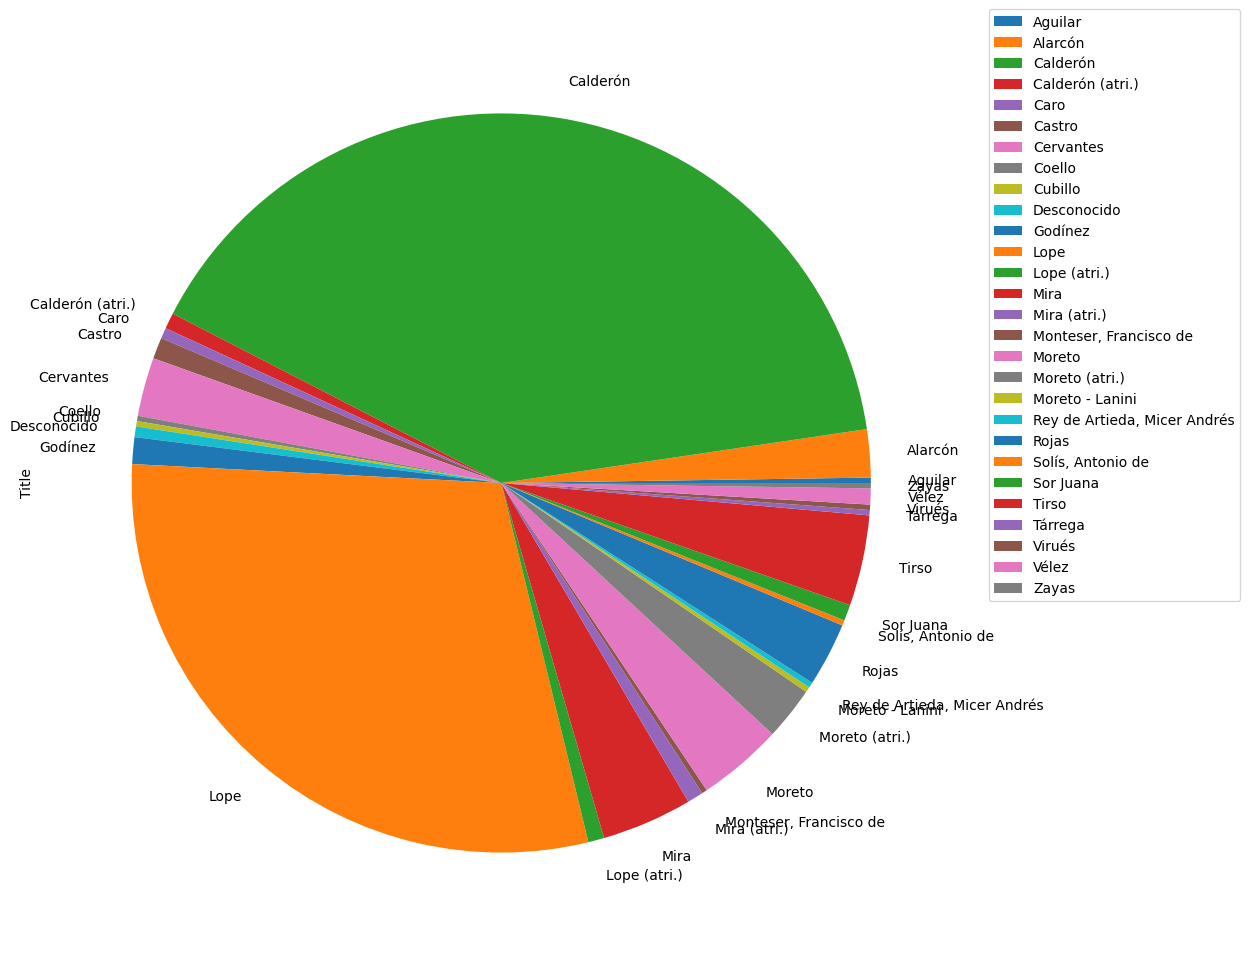

In [16]:
#We have a lot of authors in this dataframe but actually just two of them have a similar weight.
plt.figure(figsize=(20,12))
df.groupby('Author')['Title'].nunique().plot(kind='pie', legend =True)
plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

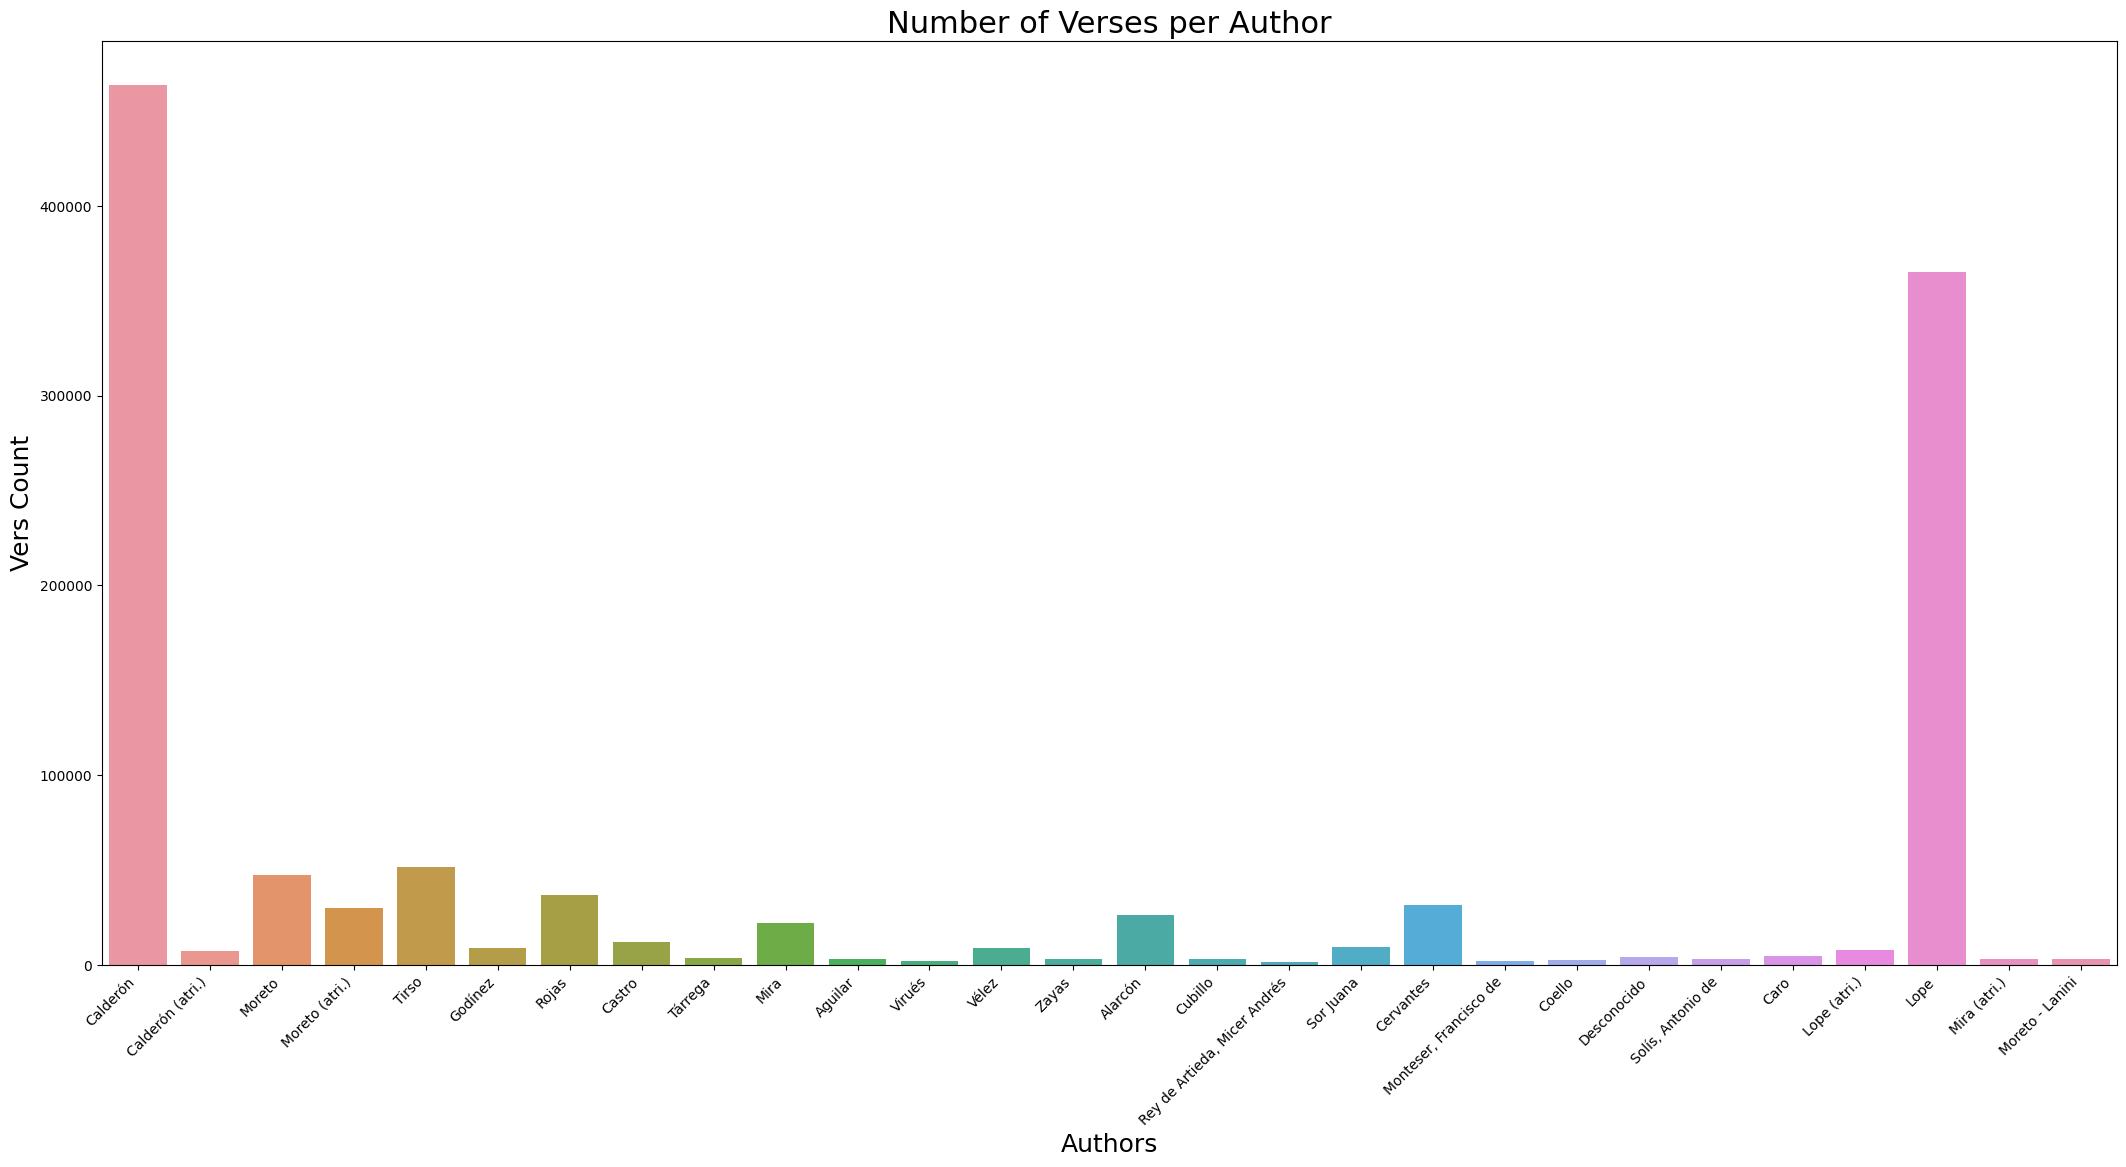

In [32]:
plt.figure(figsize=(26,12))

ax = sns.countplot(data=df, x='Author')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_title("Number of Verses per Author", fontsize=22)
ax.set_xlabel("Authors", fontsize=18)
ax.set_ylabel("Vers Count", fontsize=18)
plt.show()

<AxesSubplot:title={'center':'Percentage of playwrights in the dataframe'}, ylabel='Author'>

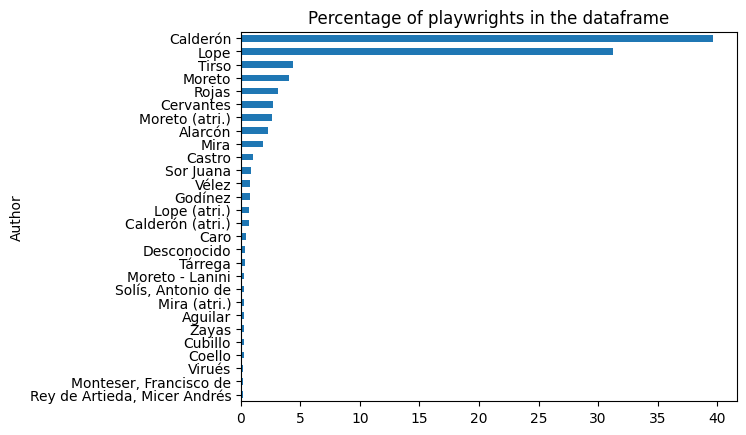

In [30]:
#Percentage of authors in relation to the whole dataframe
author = df.groupby('Author').size() / len(df) *100
plt.title('Percentage of playwrights in the dataframe')
author.sort_values(ascending = True).plot(kind = 'barh')

In [33]:
#Let's limit the data to the 65 most frequent rhythms
#From previous works we know that 65 rhythms is a good number to start with.
nritmos = 65

frecuentes = df['Rhythm'].value_counts().head(65).index.tolist()
dfg = df[df['Rhythm'].isin(frecuentes)]

In [34]:
dfg.shape

(1000525, 23)

In [35]:
#Because of the imbalance in the authors column we will convert the dataset into a binary one.
#We want to know whether Calderón's rhythm is characteristic. All non-Calderonian plays are therefore converted to "No-Calderón".

no_author = 'No Calderón'
author = 'Calderón'
candidatos = [author, no_author]


dfg.loc[dfg["Author"] != author, "Author"] = no_author

df = dfg.copy()
df.Author.unique()

array(['Calderón', 'No Calderón'], dtype=object)

In [36]:
#Applying the above functions we convert the dataframe into a dataset with columns for each rhythm.
dfcount = recount(dfg, 'Rhythm')
dflarge = largeformat(dfcount, 'Rhythm')
dflarge.head()

,Author,Title,-+-+--+,+-+---+-,-+-+--+-,--+--++-,-++---+-,-++-+-+-,---+--+,+-+-+-+,...,+--+-+---+-,-+-+---+-+-,-+---+---+-,---+---+-+-,--+--+---+-,-+---+-,--+--+-,--+--+-+-+-,+--+---+-+-,-+---+-+-+-
0,Calderón,"¿Cuál es mayor perfección, hermosura o discrec...",61,135,258,44,68,54,81,28,...,0,0,0,0,0,0,0,0,0,0
1,Calderón,"Bien vengas, mal si vienes solo",93,80,200,32,29,39,82,38,...,3,6,6,2,9,17,13,4,4,4
2,Calderón,Cada uno para sí,79,120,243,30,75,60,79,32,...,2,3,0,1,4,3,8,1,1,4
3,Calderón,Cómo se comunican dos estrellas contrarias,123,97,171,22,36,43,82,37,...,2,3,11,5,9,10,11,3,4,5
4,Calderón,Dicha y desdicha del nombre,87,126,285,43,71,72,40,38,...,5,7,3,0,5,8,11,1,2,1


In [37]:
#Some models need numnbers as target value, we replace Calderón and No Calderon with 1 and 0.
dflarge['Author'] = dflarge['Author'].replace({'Calderón' : 1, 'No Calderón' : 0 })
dflarge.head()

,Author,Title,-+-+--+,+-+---+-,-+-+--+-,--+--++-,-++---+-,-++-+-+-,---+--+,+-+-+-+,...,+--+-+---+-,-+-+---+-+-,-+---+---+-,---+---+-+-,--+--+---+-,-+---+-,--+--+-,--+--+-+-+-,+--+---+-+-,-+---+-+-+-
0,1,"¿Cuál es mayor perfección, hermosura o discrec...",61,135,258,44,68,54,81,28,...,0,0,0,0,0,0,0,0,0,0
1,1,"Bien vengas, mal si vienes solo",93,80,200,32,29,39,82,38,...,3,6,6,2,9,17,13,4,4,4
2,1,Cada uno para sí,79,120,243,30,75,60,79,32,...,2,3,0,1,4,3,8,1,1,4
3,1,Cómo se comunican dos estrellas contrarias,123,97,171,22,36,43,82,37,...,2,3,11,5,9,10,11,3,4,5
4,1,Dicha y desdicha del nombre,87,126,285,43,71,72,40,38,...,5,7,3,0,5,8,11,1,2,1


In [56]:
dflarge.shape

(427, 67)

In [38]:
# Separating the target variable 
Y = dflarge['Author']
X = dflarge.drop(['Author', 'Title'], axis = 1)

In [39]:
# Splitting the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42) 

In [40]:
#Scaling, the values differ quite much.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Cross Validation

In [41]:
#Let's try out several models
clf_dt =  DecisionTreeClassifier(random_state=RSEED)
clf_rf = RandomForestClassifier(random_state=RSEED)
clf_xg = XGBClassifier(seed=RSEED)
clf_ada = AdaBoostClassifier(random_state=RSEED)
clf_lr = LogisticRegression(random_state=RSEED)     
clf_sv = SVC(random_state=RSEED)
clf_knn =  KNeighborsClassifier()   
#clf_mnb =MultinomialNB()
clf_g = GaussianNB()

#Let's store the variantes in a list so we can loop through them
list_of_models = [clf_dt, clf_rf, clf_xg, clf_ada, clf_ada, clf_lr, clf_sv, clf_knn, clf_g]

In [42]:
#Dictionary to store result of different models
result_dict = {}
#Let's try out different models
for model in list_of_models:
    kfold = KFold(n_splits=10, random_state=RSEED, shuffle=True)
    start_time = time.time()
    name = type(model).__name__
    result_dict[name] = cross_val_predict(model, X_train, y_train, cv=kfold, n_jobs=1)
    end_time = time.time()
    print(f"{name} - Time taken: {end_time - start_time:.2f} seconds")



DecisionTreeClassifier - Time taken: 0.04 seconds
RandomForestClassifier - Time taken: 0.68 seconds
XGBClassifier - Time taken: 0.51 seconds
AdaBoostClassifier - Time taken: 0.49 seconds
AdaBoostClassifier - Time taken: 0.48 seconds
LogisticRegression - Time taken: 0.09 seconds
SVC - Time taken: 0.03 seconds
KNeighborsClassifier - Time taken: 0.01 seconds
GaussianNB - Time taken: 0.00 seconds


In [54]:
nice_scores(y_train, result_dict)

,FBeta,Accuracy,Recall,Precision
DecisionTreeClassifier,0.710,0.781,0.674,0.719
RandomForestClassifier,0.888,0.902,0.821,0.907
XGBClassifier,0.842,0.879,0.821,0.848
AdaBoostClassifier,0.898,0.914,0.853,0.910
LogisticRegression,0.942,0.953,0.926,0.946
SVC,0.904,0.922,0.874,0.912
KNeighborsClassifier,0.871,0.898,0.842,0.879
GaussianNB,0.676,0.773,0.926,0.633


## Predictions

In [44]:
pred_ytest_dict = {}
fitted_models_dict = {}
for model in list_of_models:
    start_time = time.time()
    model_name = type(model).__name__
    fitted_models_dict[model_name] = model.fit(X_train, y_train)
    pred_ytest_dict[model_name] = model.predict(X_test)
    end_time = time.time()
    print(f"{model_name} - Time taken: {end_time - start_time:.2f} seconds")



DecisionTreeClassifier - Time taken: 0.01 seconds
RandomForestClassifier - Time taken: 0.08 seconds
XGBClassifier - Time taken: 0.04 seconds
AdaBoostClassifier - Time taken: 0.05 seconds
AdaBoostClassifier - Time taken: 0.05 seconds
LogisticRegression - Time taken: 0.01 seconds
SVC - Time taken: 0.00 seconds
KNeighborsClassifier - Time taken: 0.01 seconds
GaussianNB - Time taken: 0.00 seconds


In [45]:
display(nice_scores(y_test, pred_ytest_dict))

,FBeta,Accuracy,Recall,Precision
DecisionTreeClassifier,0.753,0.784,0.776,0.747
RandomForestClassifier,0.818,0.819,0.724,0.846
XGBClassifier,0.811,0.830,0.803,0.813
AdaBoostClassifier,0.778,0.795,0.737,0.789
LogisticRegression,0.851,0.871,0.868,0.846
SVC,0.842,0.854,0.816,0.849
KNeighborsClassifier,0.777,0.813,0.842,0.762
GaussianNB,0.670,0.719,0.882,0.632


## Performing GridSearch() on the most promising models
- Logistic Regression
- AdaBoostClassifier
- SupportVectorMachine

In [53]:
#GridSerach for Logistic regression

param_grid = {'penalty': ['l2', 'elasticnet'],
              'C': [1, 2, 3, 4,5],
              'fit_intercept': [True, False],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}




# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf_lr, param_grid, scoring=scorer, verbose=1, n_jobs=-1)

#Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = clf_lr.fit(X_train, y_train).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib

Unoptimized model
------
Accuracy score on testing data: 0.8713
F-score on testing data: 0.8505

Optimized Model
------
Final accuracy score on the testing data: 0.8713
Final F-score on the testing data: 0.8505
LogisticRegression(C=1, random_state=42)


/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib

In [68]:
#GridSearch for SVC

param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 1000, 2000],
              'gamma': [0.01, 0.1, 1, 10, 100, 'scale', 'auto'],
              'degree' : [20],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'max_iter' : [6000],
              'decision_function_shape': ['ovo', 'ovr']}



# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf_B, param_grid, scoring=scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = clf_B.fit(X_train, y_train).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000

Unoptimized model
------
Accuracy score on testing data: 0.8655
F-score on testing data: 0.8611

Optimized Model
------
Final accuracy score on the testing data: 0.8889
Final F-score on the testing data: 0.8777
SVC(C=100, decision_function_shape='ovo', degree=20, max_iter=6000)


/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/simonkroll/Documents/machine-learning-rhythm-authorship/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [70]:
#GridSearch for xgboost

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }



# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(xboost, params, scoring=scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = xboost.fit(X_train, y_train).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Unoptimized model
------
Accuracy score on testing data: 0.8304
F-score on testing data: 0.8112

Optimized Model
------
Final accuracy score on the testing data: 0.8304
Final F-score on the testing data: 0.8152
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ra

In [71]:
# create loocv procedure
cv = LeaveOneOut()
# create model
model = logistic_regression
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
# evaluate model
scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.934 (0.248)


## 